In [11]:
from data_utils import split_ad

from nanoTxformer.model import nanoTxformer
from nanoTxformer.train import train_model
from nanoTxformer.utils import get_mean_pooled_embeddings
import scanpy as sc
from latentmi import lmi
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

from scipy.stats import rankdata
from sklearn.random_projection import GaussianRandomProjection

In [2]:
adata = sc.read_h5ad('data/PBMC_CITEseq_Q1.000_rep0.h5ad')
seen, held_out = split_ad(adata, frac=0.75)
seen = seen[:2*10**4]

In [3]:
model = nanoTxformer(seen, embed_size=512, 
                    num_heads=2, num_encoder_layers=6).cuda()

losses = train_model(model, seen, epochs=200)
# emb = get_mean_pooled_embeddings(model, held_out).cpu()
# pmis, _, _ = lmi.estimate(emb, held_out.obsm['protein_counts'], 
#                     quiet=True, batch_size=2048)

epoch 2/200 (batch 1000) - train loss: 5.0675, val loss: 3.5137
epoch 4/200 (batch 2000) - train loss: 1.2555, val loss: 1.2204
epoch 6/200 (batch 3000) - train loss: 1.1486, val loss: 1.1431
epoch 8/200 (batch 4000) - train loss: 1.0693, val loss: 1.0513
epoch 10/200 (batch 5000) - train loss: 0.9750, val loss: 0.9718
epoch 12/200 (batch 6000) - train loss: 0.9281, val loss: 0.9345
epoch 14/200 (batch 7000) - train loss: 0.9112, val loss: 0.9207
epoch 16/200 (batch 8000) - train loss: 0.9062, val loss: 0.9105
epoch 18/200 (batch 9000) - train loss: 0.8996, val loss: 0.9104
epoch 20/200 (batch 10000) - train loss: 0.8933, val loss: 0.9068
epoch 22/200 (batch 11000) - train loss: 0.8938, val loss: 0.9079
Early stopping triggered at epoch 22, batch 11000


In [4]:
def counts_to_ranks(ad):
    n_ad = model.tokenizer.normalize_with_stored_medians(ad)
    return np.apply_along_axis(rankdata, 1, n_ad.X)

In [5]:
d = {
    "Model" : [],
    "UMI per cell" : [],
    "Quality" : [],
    "MI" : []
}

qualities = np.logspace(-3, 0, 10)

for qual in qualities:

    ad = sc.read_h5ad('data/PBMC_CITEseq_Q%.3f_rep0.h5ad' % qual)
    emb = get_mean_pooled_embeddings(model, ad[held_out.obs.index])
    pmis, _, _ = lmi.estimate(emb.cpu(), held_out.obsm['protein_counts'], 
                    quiet=True, batch_size=2048)
    
    d['Model'].append("nanoTxformer")
    d['UMI per cell'].append(ad.raw.X.sum()/len(ad))
    d['Quality'].append(qual)  
    d['MI'].append(np.nanmean(pmis))

    rand_proj = GaussianRandomProjection(n_components=512)
    emb = rand_proj.fit_transform(np.asarray(ad[held_out.obs.index].X.todense()))
    pmis, _, _ = lmi.estimate(emb, held_out.obsm['protein_counts'], 
                        quiet=True, batch_size=2048)
    
    d['Model'].append("Random projection")
    d['UMI per cell'].append(ad.raw.X.sum()/len(ad))
    d['Quality'].append(qual)  
    d['MI'].append(np.nanmean(pmis))

    n_ad = counts_to_ranks(ad[held_out.obs.index])
    emb = rand_proj.fit_transform(np.asarray(n_ad))
    pmis, _, _ = lmi.estimate(emb, held_out.obsm['protein_counts'], 
                        quiet=True, batch_size=2048)
    
    d['Model'].append("Rank random projection")
    d['UMI per cell'].append(ad.raw.X.sum()/len(ad))
    d['Quality'].append(qual)  
    d['MI'].append(np.nanmean(pmis))


epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

In [6]:
df = pd.DataFrame(d)
df

,Model,UMI per cell,Quality,MI
0,nanoTxformer,8.156739,0.001000,0.369801
1,Random projection,8.156739,0.001000,0.474997
2,Rank random projection,8.156739,0.001000,0.468676
3,nanoTxformer,17.573159,0.002154,0.711364
4,Random projection,17.573159,0.002154,0.772508
5,Rank random projection,17.573159,0.002154,0.725937
6,nanoTxformer,37.860225,0.004642,1.147232
7,Random projection,37.860225,0.004642,1.191029
8,Rank random projection,37.860225,0.004642,1.135710
9,nanoTxformer,81.567386,0.010000,1.579336


In [7]:
df.to_csv("results/PBMC_CITEseq_inference_time_scaling_nanoTx.csv")

In [12]:
import glob

file_paths = glob.glob("results/PBMC_CITEseq_inference*.csv")

# Load each CSV file into a separate dataframe
dfs = [pd.read_csv(file_path) for file_path in file_paths]

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined dataframe
combined_df

,Unnamed: 0,Model,UMI per cell,Quality,MI
0,0,Geneformer,8156.738859,0.001000,0.400300
1,1,Geneformer,8156.738859,0.002154,0.634460
2,2,Geneformer,8156.738859,0.004642,0.873613
3,3,Geneformer,8156.738859,0.010000,1.165143
4,4,Geneformer,8156.738859,0.021544,1.640392
5,5,Geneformer,8156.738859,0.046416,2.109491
6,6,scGPT,8156.738859,0.046416,2.440719
7,7,Geneformer,8156.738859,0.100000,2.460914
8,8,scGPT,8156.738859,0.100000,2.695092
9,9,Geneformer,8156.738859,0.215443,2.608272


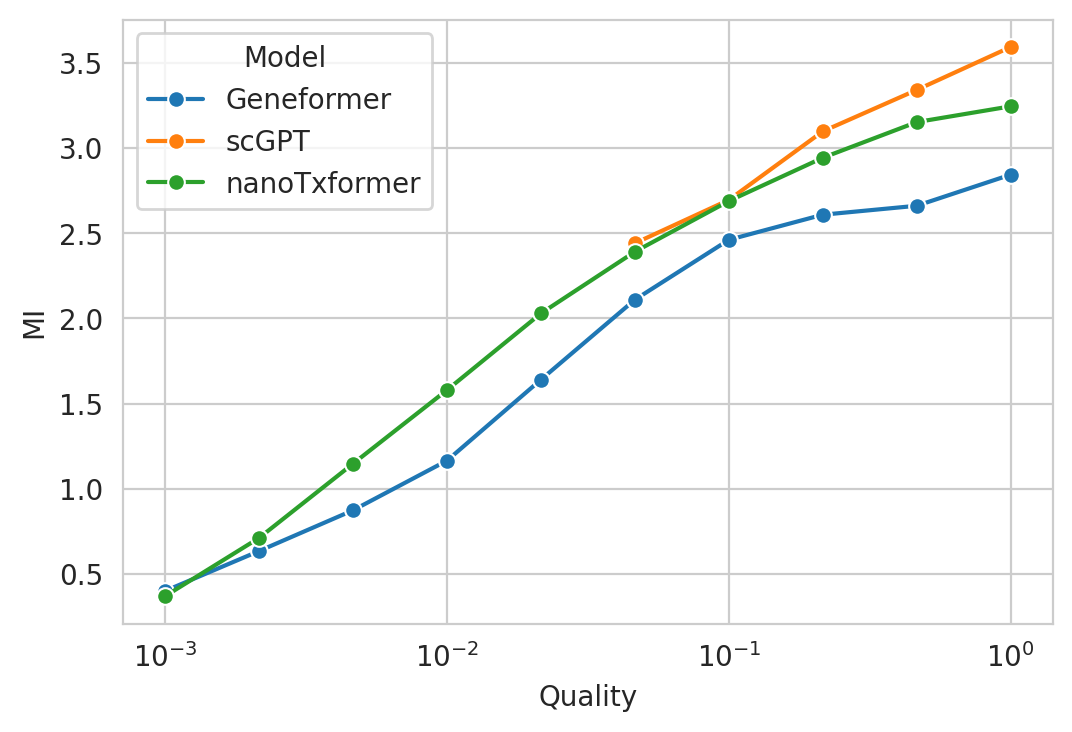

In [13]:
rcParams['figure.dpi'] = 200
toplot = ['scGPT', 'nanoTxformer', 'Geneformer']
sns.set_style('whitegrid')
sns.lineplot(data=combined_df[combined_df['Model'].isin(toplot)], x='Quality', y='MI', hue='Model',
             marker='o')
plt.xscale('log')